In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import os
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def citf(image):
    image = image.reshape((256,256))
    tmp = np.fft.fftshift(cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT))
    complex_matrix = tmp[:,:,0] + 1j * tmp[:,:,1]
    complex_matrix = complex_matrix.reshape((256,256,1))
    return complex_matrix

In [3]:
def cfti(kspace):
    kspace = kspace.reshape((256,256))
    img_inverse = np.flipud(np.fliplr(np.abs(np.fft.ifft2(kspace))))
    img_inverse = img_inverse.reshape((256,256,1))
    return img_inverse

In [4]:
def show_both(kspace):
    temp = kspace.reshape((256,256))
    mag_spe = 20*np.log(np.abs(temp))
    plt.subplot(121), plt.imshow(cfti(kspace).reshape((256,256)), cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(mag_spe, cmap='gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()

In [5]:
def diff(t_kspace , u_kspace):
    plt.subplot(121), plt.imshow(cfti(t_kspace).reshape((256,256)), cmap='gray')
    plt.title('Ground Truth'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(cfti(u_kspace).reshape((256,256)), cmap='gray')
    plt.title('Undersampled Image'), plt.xticks([]), plt.yticks([])
    plt.show()

In [6]:
images = []
def process_file(file_path):
    if "mask" in file_path or "README" in file_path or ".csv" in file_path:
        time.sleep(0)
    else:
        image = cv2.imread(file_path,0)
        image = np.array(image)
        image = image.reshape((256,256,1))
        image = image.astype('float32') / 255.0
        images.append(image)
        return
for folder_name, subfolders, filenames in os.walk("/kaggle/input/lgg-mri-segmentation/kaggle_3m"):
    for filename in filenames:
        if "mask" not in filename:
            file_path = os.path.join(folder_name, filename)
            process_file(file_path)
images = np.asarray(images)

In [7]:
images.shape

(3929, 256, 256, 1)

In [8]:
kspaces = []
for image in images:
    kspace = citf(image)
    kspaces.append(np.array(kspace))
kspaces = np.asarray(kspaces)

In [9]:
kspaces.shape

(3929, 256, 256, 1)

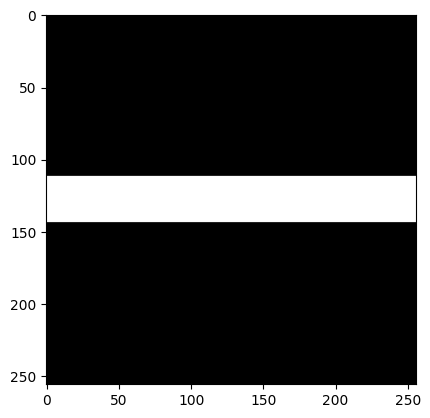

In [10]:
mask = np.zeros((256,256))
mask[112:144,:] = np.ones((32,256))
plt.imshow(mask, cmap='gray')

In [11]:
def unsample_data(data, mask):
    u_kspaces = []
    u_images = []
    for i in range(kspaces.shape[0]):
        u_kspace = np.multiply(kspaces[i,:,:].reshape(256,256), mask)
        u_kspace = u_kspace.reshape((256,256,1))
        u_kspaces.append(u_kspace)
        u_images.append(cfti(u_kspace))
    return np.array(u_kspaces) , np.array(u_images)

In [12]:
u_kspaces , u_images = unsample_data(kspaces,mask)

In [13]:
u_kspaces.shape

(3929, 256, 256, 1)

In [14]:
u_images.shape

(3929, 256, 256, 1)

In [15]:
np.savez('data.npz',kspaces=kspaces , u_kspaces = u_kspaces , images=images , u_images=u_images)

In [ ]:
import numpy as np
data = np.load('data.npz')
kspaces = data['kspaces']
u_kspaces = data['u_kspaces']
images = data['images']
u_images = data['u_images']

/tmp/ipykernel_47/1401412311.py:3: RuntimeWarning: divide by zero encountered in log
  mag_spe = 20*np.log(np.abs(temp))


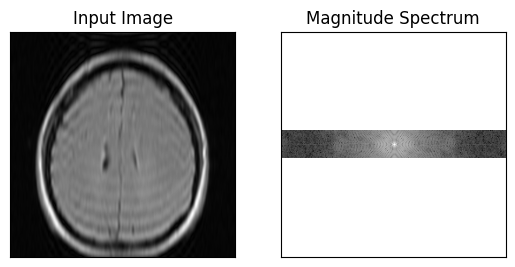

In [16]:
show_both(u_kspaces[101,:,:])

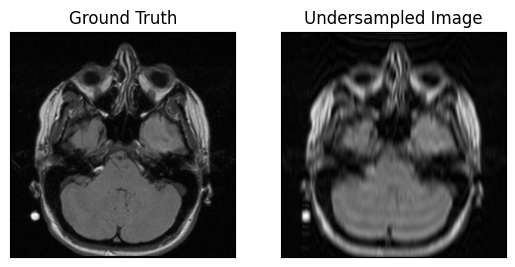

In [17]:
diff(kspaces[100,:,:],u_kspaces[100,:,:])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(u_images , images , test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def res_block(x, filters, kernel_size=3, stride=1, padding='same'):
    """Residual block."""
    res = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding=padding, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, res])
    x = layers.Activation('relu')(x)
    return x

def ResNet(input_shape, num_residual_blocks):
    """Builds the ResNet."""
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    # Input Down-sampling
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    
    # Residual Blocks
    for _ in range(num_residual_blocks):
        x = res_block(x, 64)
    
    # Output Up-sampling
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    
    # Final Convolution Layer
    outputs = layers.Conv2D(1, (7, 7), strides=1, padding='same', activation='sigmoid')(x)
    
    # Define the model
    model = models.Model(inputs, outputs)
    
    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss=ssim_loss)
    
    return model

# Set input shape and number of residual blocks based on the paper
input_shape = (256,256, 1)  # Assuming grayscale MRI images with variable size
num_residual_blocks = 34

# Create the model
model = ResNet(input_shape, num_residual_blocks)

# Model summary
model.summary()

In [ ]:
model.fit(X_train,Y_train, validation_split=0.2, epochs=10)

In [ ]:
model.save_weights('model25.h5')

In [ ]:
a = model.history.history['val_loss']
b = model.history.history['loss']
print(a)
print(b)

In [ ]:
plt.plot(b , label="Training loss")
plt.plot(a , label="Validation loss")
plt.legend()
plt.show()

In [ ]:
model.load_weights('model25.h5')

In [ ]:
output_images = model.predict(X_test)

In [ ]:
# Finding the inverse of mask
inv_mask = np.ones((256,256))
inv_mask[112:144,:] = np.zeros((32,256))
plt.imshow(inv_mask,cmap='gray')

In [ ]:
recon_kspaces = []
recon_images = []
for i in range(len(output_images)):
    r_kspace = np.array(citf(output_images[i]))
    r_kspace = np.multiply(r_kspace , inv_mask)
    r_kspace = r_kspace + citf(X_test[i])
    recon_kspaces.append(r_kspace)
    recon_images.append(cfti(r_kspace))
recon_kspaces = np.asarray(recon_kspaces)
recon_images = np.asarray(recon_images)

In [ ]:
plt.subplot(131), plt.imshow(Y_test[2], cmap='gray')
plt.title('Ground Truth'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(X_test[2], cmap='gray')
plt.title('Undersampled Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(recon_images[2], cmap='gray')
plt.title('Reconstructed Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [18]:
import numpy as np 
import glob
import nibabel as nib 
import os
import pickle 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from skimage import measure
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import tensorflow as tf 
from tensorflow.keras.models import Model 
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Add 
from tensorflow.keras.layers import Concatenate, Activation 
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import RandomNormal 
# from keras.initializers import RandomNormal
# from tensorflow.python.keras.utils import multi_gpu_model

In [19]:
# loss for dicriminator 

def accw(y_true, y_pred):
    y_pred = K.clip(y_pred, -1 , 1)
    
    return K.mean (K.equal(y_true, K.round(y_pred)))


def mssim(y_true, y_pred):
    costs = 1.0 -tf.reduce_mean(tf.image.ssim(y_true,y_pred, 2.0))
    
    return costs 

def wloss(y_true, y_predict):
    
    return -K.mean(y_true+y_predict)


In [20]:
def discriminator(inp_shape = (256,256,1), trainable = True):
    gamma_init = RandomNormal(1. , 0.02)
    
    inp = Input(shape =(256,256,1))
    
    l0 = Conv2D(64, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(inp)
    l0 = LeakyReLU(alpha=0.2)(l0)
    
    l1 = Conv2D(64*2, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l0)
    l1 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l1)
    l1 = LeakyReLU(alpha=0.2)(l1)
    
    l2 = Conv2D(64*2, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l1)
    l2 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l2)
    l2 = LeakyReLU(alpha=0.2)(l2)
    
    l3 = Conv2D(64*8, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l2)
    l3 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l3)
    l3 = LeakyReLU(alpha=0.2)(l3)
    
    l4 = Conv2D(64*16, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l3)
    l4 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l4)
    l4 = LeakyReLU(alpha=0.2)(l4)
    
    l5 = Conv2D(64*32, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l4)
    l5 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l5)
    l5 = LeakyReLU(alpha=0.2)(l5)
    
    l6 = Conv2D(64*16, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l5)
    l6 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l6)
    l6 = LeakyReLU(alpha=0.2)(l6)
    
    l7 = Conv2D(64*8, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l6)
    l7 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l7)
    l7 = LeakyReLU(alpha=0.2)(l7)
    
    l8 = Conv2D(64*2, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l7)
    l8 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l8)
    l8 = LeakyReLU(alpha=0.2)(l8)
    
    l9 = Conv2D(64*2, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l8)
    l9 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l9)
    l9 = LeakyReLU(alpha=0.2)(l9)
    
    l10 = Conv2D(64*8, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l9)
    l10 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l10)
    l10 = LeakyReLU(alpha=0.2)(l10)
    
    l11 = Add()([l7,l10])
    l11 = LeakyReLU(alpha = 0.2)(l11)
    
    out =  Conv2D(filters = 1, kernel_size = 3, strides = 1, padding= 'same',use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l11)
    model = Model(inputs = inp, outputs = out )
    return model 

In [21]:
def resden(x,fil,gr,beta, gamma_init, trainable):
    
    x1 = Conv2D(filters=gr, kernel_size=3, strides = 1, padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(x)
    x1 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x1)
    x1 = LeakyReLU(alpha=0.2)(x1)
    
    x1 = Concatenate(axis = -1 )([x,x1])
    
    x2 = Conv2D(filters=gr, kernel_size=3, strides = 1, padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(x1)
    x2 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)
    
    x2 = Concatenate(axis = -1 )([x1,x2])
    
    x3 = Conv2D(filters=gr, kernel_size=3, strides = 1, padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(x2)
    x3 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x3)
    x3 = LeakyReLU(alpha=0.2)(x3)

    x3 = Concatenate(axis = -1 )([x2,x3])
    
    x4 = Conv2D(filters=gr, kernel_size=3, strides = 1, padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(x3)
    x4 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x4)
    x4 = LeakyReLU(alpha=0.2)(x4)
    
    x4 = Concatenate(axis = -1 )([x3,x4])
    
    x5 = Conv2D(filters=fil, kernel_size=3, strides = 1, padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(x4)
    x5 = Lambda(lambda x:x-beta)(x5)
    xout = Add()([x5,x])
    
    return xout 



In [22]:
def resresden(x,fil,gr,betad, betar, gamma_init, trainable):
    
    x1=resden(x,fil,gr,betad,gamma_init,trainable)
    x2=resden(x1,fil,gr,betad,gamma_init,trainable)
    x3=resden(x2,fil,gr,betad,gamma_init,trainable)
    x3=Lambda(lambda x:x-betar)(x3)
    xout = Add()([x3,x])
    
    return xout 



In [23]:
def generator(inp_shape, trainable = True):
    
    gamma_init = RandomNormal(1.,0.02)
    
    fd =512
    gr =32
    nb =12
    betad =0.2
    betar =0.2
    
    inp_real_imag = Input(inp_shape)
    lay_128dn =  Conv2D(64, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(inp_real_imag)
    lay_128dn = LeakyReLU(alpha=0.2)(lay_128dn)
    print("lay_128dn",lay_128dn.shape)
    
    lay_64dn =  Conv2D(128, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_128dn)
    lay_64dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_64dn)
    lay_64dn = LeakyReLU(alpha=0.2)(lay_64dn)
    print("lay_64dn",lay_64dn.shape)
    
    lay_32dn =  Conv2D(256, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_64dn)
    lay_32dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_32dn)
    lay_32dn = LeakyReLU(alpha=0.2)(lay_32dn)
    print("lay_32dn",lay_32dn.shape)
    
    lay_16dn =  Conv2D(512, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_32dn)
    lay_16dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_16dn)
    lay_16dn = LeakyReLU(alpha=0.2)(lay_16dn)
    print("lay_16dn",lay_16dn.shape)
    
    lay_8dn =  Conv2D(512, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_16dn)
    lay_8dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_8dn)
    lay_8dn = LeakyReLU(alpha=0.2)(lay_8dn)
    print("lay_8dn",lay_8dn.shape)
    
    xc1 =  Conv2D(filters=fd,kernel_size=3, strides = 1, padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_8dn)
    xrrd=xc1
    
    
    for m in range(nb):
        xrrd =  resresden(xrrd,fd,gr,betad, betar, gamma_init, trainable)
    
    xc2 = Conv2D(filters=fd,kernel_size=3, strides = 1, padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(xrrd)
    lay_8upc = Add()([xc1,xc2])
    
    lay_16up = Conv2DTranspose(1024, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_8upc)
    lay_16up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_16up)
    lay_16up = Activation('relu')(lay_16up)
    print("lay_16up",lay_16up.shape)
    
    lay_16upc = Concatenate(axis = -1)([lay_16up, lay_16dn])
    print(lay_16upc.shape)
    
    lay_32up =  Conv2DTranspose(256, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_16upc)
    lay_32up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_32up)
    lay_32up = Activation('relu')(lay_32up)
    print("lay_32up",lay_32up.shape)
    
    lay_32upc = Concatenate(axis = -1)([lay_32up, lay_32dn])
    
    lay_64up =  Conv2DTranspose(128, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_32upc)
    lay_64up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_64up)
    lay_64up = Activation('relu')(lay_64up)
    print("lay_64up",lay_64up.shape)
    
    lay_64upc = Concatenate(axis = -1)([lay_64up, lay_64dn])
    
    
    lay_128up =  Conv2DTranspose(64, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_64upc)
    lay_128up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_128up)
    lay_128up = Activation('relu')(lay_128up)
    print("lay_128up",lay_128up.shape)
    
    lay_128upc = Concatenate(axis = -1)([lay_128up, lay_128dn])
    
    lay_256up =  Conv2DTranspose(64, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_128upc)
    lay_256up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_256up)
    lay_256up = Activation('relu')(lay_256up)
    print("lay_256up",lay_256up.shape)
    
    out = Conv2D(1, (1,1),strides =(1,1), activation = 'tanh', padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_256up)
    
    model = Model(inputs =inp_real_imag, outputs = out )
    
    return model 

    

In [24]:
def define_gan_model(gen_model, dis_model, inp_shape):
    
    dis_model.trainable = False
    inp =Input(shape = inp_shape)
    out_g = gen_model(inp)
    
    out_dis = dis_model(out_g)
    
    out_g1 = out_g
    
    model = Model(inputs = inp, outputs =[out_dis, out_g, out_g1])
    
    model.summary()
    
    return model
    
    
    

In [30]:
def train(g_par, d_par, gan_model, dataset_real, u_sampled_data, n_epochs, n_batch, n_critic, clip_val, n_patch):
    
    bat_per_epo = 10
    half_batch = 5
    
    for i in range(n_epochs):
        print('Epochs', i)
        
        for j in range(bat_per_epo):
            
            print('Batch', j)
            
            for k in range(n_critic):
                ix = np.random.randint(0, dataset_real.shape[0], half_batch)
                
                X_real = dataset_real[ix]
                y_real = np.ones((half_batch, n_patch, n_patch, 1))
                
                ix_1 = np.random.randint(0, u_sampled_data.shape[0], half_batch)
                X_fake = g_par.predict(u_sampled_data[ix_1])
                y_fake = -np.ones((half_batch, n_patch, n_patch, 1))
                
                X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
                
                d_loss, accuracy = d_par.train_on_batch(X, y)
                
                for L in d_par.layers:
                    weights = L.get_weights()
                    weights = [np.clip(w, clip_val, clip_val) for w in weights]
                    L.set_weights(weights)
                    
            ix = np.random.randint(0, dataset_real.shape[0], n_batch)

            X_r = dataset_real[ix]
            
            X_gen_inp = u_sampled_data[ix]
            y_gan = np.ones((n_batch, n_patch, n_patch, 1))
            
            g_loss = gan_model.train_on_batch([X_gen_inp], [y_gan, X_r, X_r])
            
            print('>%d, %d/%d, d = %.3f, acc = %.3f, g = %.3f' % (i+1, j+1, bat_per_epo, d_loss, accuracy, g_loss[0]))
            
#         filename = 'gen_weight/gen_weights_a5_04d.h5' % (i+1)
#         g_par.save_weights(filename)


                

In [31]:

# data_path = 'preprocessed_data/training.pickle'
# usam_path = 'preprocessed_data/training_usamp.pickle'

# dataset_real = pickle.load(open(data_path,'rb'))

# u_sampled_data = pickle.load(open(usam_path,'rb'))
                             
# dataset_real = np.expand_dims(dataset_real, axis = -1)

# u_sampled_data = np.expand_dims(u_sampled_data, axis = -1)
                             
somthing = np.concatenate((u_kspaces.real, u_kspaces.imag), axis = -1)
                             
# print(dataset_real.shape)

# dataset_real = X_train 
# print(dataset_real.shape)










In [27]:
somthing.shape

(3929, 256, 256, 2)

In [32]:
n_epochs = 5
n_batch = 10
n_critic = 3

clip_val =0.05
in_shape_gen = (256,256,2)
in_shape_dis = (256,256,1)
accel = 3

d_model = discriminator(inp_shape = in_shape_dis, trainable =True)

# d_model.summary()

d_par = d_model
opt = Adam(lr = 0.0002, beta_1 =0.5)
d_par.compile(loss = wloss, optimizer = opt, metrics = [accw])

g_model = generator(inp_shape =in_shape_gen, trainable = True)

g_par =g_model
# g_par.summary()

gan_model = define_gan_model(g_par, d_par, in_shape_gen)

opt1 = Adam(lr =0.0001 , beta_1 = 0.5)

gan_model.compile(loss =[wloss, 'mae', mssim], optimizer = opt1, loss_weights = [0.01, 20.0, 1.0])
n_patch = d_model.output_shape[1]

lay_128dn (None, 128, 128, 64)
lay_64dn (None, 64, 64, 128)
lay_32dn (None, 32, 32, 256)
lay_16dn (None, 16, 16, 512)
lay_8dn (None, 8, 8, 512)
lay_16up (None, 16, 16, 1024)
(None, 16, 16, 1536)
lay_32up (None, 32, 32, 256)
lay_64up (None, 64, 64, 128)
lay_128up (None, 128, 128, 64)
lay_256up (None, 256, 256, 64)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 2)]     0         
                                                                 
 model_4 (Functional)        (None, 256, 256, 1)       157239297 
                                                                 
 model_3 (Functional)        (None, 1, 1, 1)           87723585  
                                                                 
Total params: 244962882 (934.46 MB)
Trainable params: 157224193 (599.76 MB)
Non-trainable params: 87738689 (334.70 MB)
_____________________

In [33]:
train(g_par, d_par, gan_model, images ,somthing, n_epochs, n_batch, n_critic, clip_val, n_patch)

Epochs 0
Batch 0
1/1 [==============================] - 0s 51ms/step
>1, 1/10, d = -2.610, acc = 0.500, g = -110803927040.000
Batch 1
1/1 [==============================] - 0s 49ms/step
>1, 2/10, d = -2.610, acc = 0.500, g = -213475835904.000
Batch 2
1/1 [==============================] - 0s 50ms/step
>1, 3/10, d = -2.610, acc = 0.500, g = -289317912576.000
Batch 3
1/1 [==============================] - 0s 51ms/step
>1, 4/10, d = -2.610, acc = 0.500, g = -373264809984.000
Batch 4
1/1 [==============================] - 0s 55ms/step
>1, 5/10, d = -2.610, acc = 0.500, g = -425929015296.000
Batch 5
1/1 [==============================] - 0s 51ms/step
>1, 6/10, d = -2.610, acc = 0.500, g = -496392142848.000
Batch 6
1/1 [==============================] - 0s 49ms/step
>1, 7/10, d = -2.610, acc = 0.500, g = -548614602752.000
Batch 7
1/1 [==============================] - 0s 51ms/step
>1, 8/10, d = -2.610, acc = 0.500, g = -607003279360.000
Batch 8
1/1 [==============================] - 0s 51ms/

In [35]:
new = g_model.predict(somthing)

123/123 [==============================] - 43s 327ms/step


In [36]:
new.shape

(3929, 256, 256, 1)

In [37]:
ne = new[0,:,:,:]

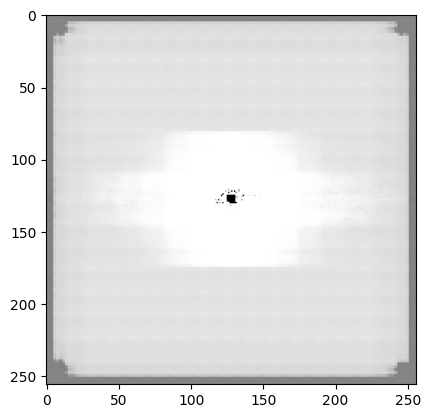

In [38]:
plt.imshow(ne.reshape((256,256)), cmap='gray')

# Test Model 

In [ ]:
def metrics(true_tensor, test_tensor, max_val):
    
    psnrt = 0
    ssimt = 0
    
    
    for i in range(true_tensor.shape[0]):
        
        true_image = np.squeeze(true_tensor[i,:,:])
        test_image = np.squeeze(test_tensor[i,:,:])
        
        psnr = peak_signal_noise_ratio(true_image, test_image, data_range=max_val)
        
        ssim = structural_similarity(true_image, test_image, data_range=max_val)
        psnrt = psnrt + psnr
        
        ssimt = ssimt + ssim
        
        psnrt = psnrt/true_tensor.shape[0]
        ssimt = ssimt/true_tensor.shape[0]
        
        return psnrt, ssimt
    
    
        

In [ ]:

# data_path = 'preprocessed_data/training.pickle'
# usam_path = 'preprocessed_data/training_usamp.pickle'
# dataset_real = pickle.load(open(data_path,'rb'))
# u_sampled_data = pickle.load(open(usam_path,'rb'))
                             

                             
data = np.asarray(dataset_real, dtype ='float32')
usp_data = np.expand_dims(u_sampled_data, axis = -1)
data_gen = np.concatenate((usp_data.real,usp_data.imag), axis = -1)

In [ ]:
gen16 = generator(inp_shape = (256,256,2), trainable = False)
gen16.load_weights('gen_weights/gen_weights_a5_0004.h5')

out16 = gen16.predict(data_gen)

psnr, ssim = metrics(data, out16[:,:,:,0], 2.0)

print(psnr, ssim)



In [ ]:
plot_no = 1

fig, ax = plt.subplots(1,3, figsize=(20,5))
ax[0].imshow(data[plot_no],cmap='gray')
ax[0].set_title('Ground Truth')
ax[1].imshow(np.squeeze(usp_data[plot_no].real), cmap ='gray')
ax[1].set_title('Undersampled Image')
ax[2].imshow(np.squeeze(out16[plot_no]), cmap='gray')
ax[2].set_title('Reconstructed  Image')
plt.show